In [2]:
"""
This script is used to enhence Alpha9 with the additional earning predicting power from dataset1, 2, ..., 7; 
Seems very likely these datasets are betting on upcoming earning prints 

Alpha1, 2, ...,7 from Dataset1, 2, ...,7 are event driven strategies, trading them alone could be quite risky here, 
so I prefer to use them helping Alpha9, who has descent breadth and traded daily
"""

%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce

from scipy.stats import norm
import seaborn as sns

import sys
sys.path.append('..') # Adds higher directory to python modules path.
print(os.getcwd())

# Load utils functions
from math_trend import *
from utils import *

plt.rcParams['figure.figsize'] = [15, 7]
plt.style.use("ggplot")

# settings
ROOT = '/home/jma/Python3.7/Cubist_2021_11' ### please make sure you change root before the run
PROCESSED_DATA_DIR = '/home/jma/Python3.7/Cubist_2021_11/processed_data'

in_sample_start_date = '2011-01-01'
in_sample_end_date = '2016-01-01'

dtcol = 'pos_date'
seccol = 'security_id'
dscols = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']

print("There are 5 years' in-sample data, 2 years' out-of-sample data")

## All 7 indicators seem to be related to earning announcements. 
## from Spearman rank correlation, d7 has negative IC with fwdretf1, similar magnituide as d9 
big_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'known_df_on_data_date.csv.gz'),
                    parse_dates=[dtcol], dtype={seccol: str}, 
                    usecols=[dtcol, seccol] + dscols + ['clip_trisk', 'fwdret_f1', 'sector', 'in_trading_universe'])

assert not big_df.duplicated(subset=[dtcol, seccol]).any(), f"There are duplicated {dtcol} and {seccol}!"

print("Getting the complete trading universe")
rsch_universe = big_df[[dtcol, seccol]].copy()

/home/jma/Python3.7/Cubist_2021_11/alphas
There are 5 years' in-sample data, 2 years' out-of-sample data
Getting the complete trading universe


<AxesSubplot:title={'center':'Daily number of stocks within trading universe'}, xlabel='pos_date'>

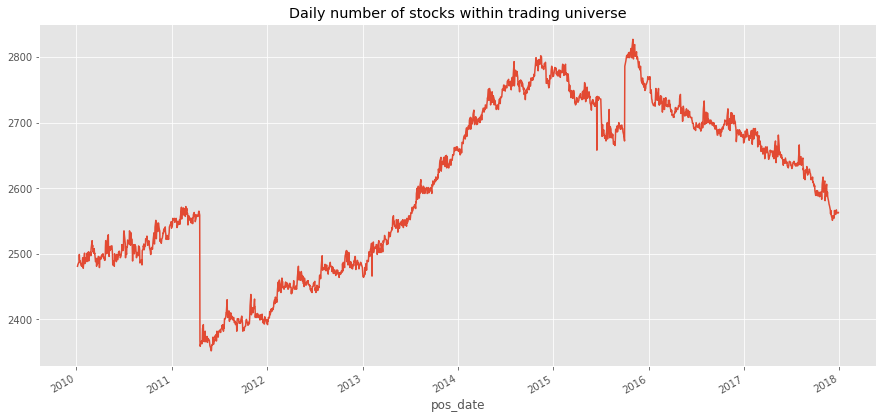

In [3]:
rsch_universe.groupby(dtcol).size().plot(title='Daily number of stocks within trading universe')

In [5]:
big_df.sort_values(by=[dtcol, seccol], inplace=True)
big_df.dropna(subset=dscols, how='all', inplace=True)

In [7]:
# print(big_df.head(), '\n')
print(f"big_df.tail():\n{big_df.tail()}\n")
print(f"big_df.shape:{big_df.shape}\n")
print(f"big_df descriptive stats:\n{big_df[dscols].describe()}\n")

big_df.tail():
        security_id       d1        d2        d3       d4        d5      d6  \
5223406     5464701   98.300   923.200  0.038511  18.2145  0.012644  0.9525   
5223532      597001   13.309    55.584  0.034698  13.1837  0.021558  0.5578   
5223828       78001    1.000   -20.100 -0.012298   1.9796 -0.020741  0.0655   
5223968     8386601  872.486  4330.280  0.047501  22.1053  0.016434  0.0925   
5225540     3538501  -23.224    37.843  0.028153 -52.7621 -0.443291 -0.8603   

             d7   pos_date  fwdret_f1 in_trading_universe  \
5223406 -0.1531 2017-12-26  -0.006536                   Y   
5223532 -0.0714 2017-12-26  -0.003113                   Y   
5223828  0.0093 2017-12-26  -0.012453                   Y   
5223968 -0.2605 2017-12-26   0.002157                   Y   
5225540 -0.5744 2017-12-27   0.046875                   N   

                         sector  clip_trisk  
5223406  Information Technology   14.661838  
5223532             Industrials   28.930722  
52238

Plotting out daily number stocks covered by at least 1 out of the 7 datasets


<AxesSubplot:xlabel='pos_date'>

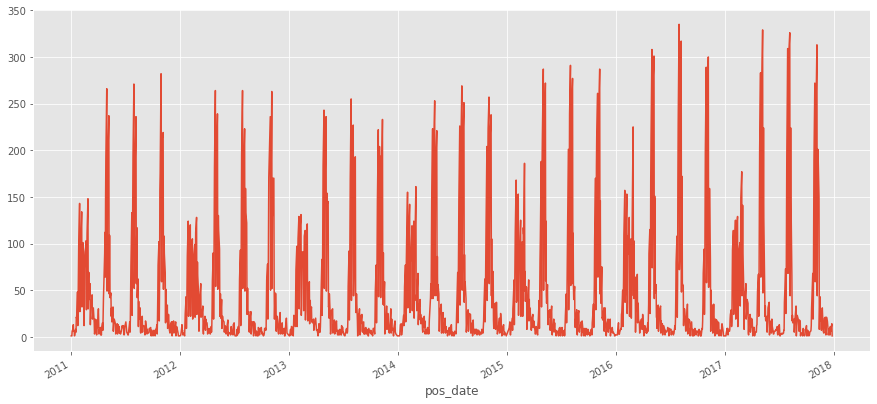

In [8]:
print("Plotting out daily number stocks covered by at least 1 out of the 7 datasets")
big_df.loc[big_df[dtcol] >= in_sample_start_date].groupby(dtcol).size().plot()

## Computing the Spearman rank correlation between raw data and forward 1 day's return, d1, d3 and d5 are the three with highest correlation

In [11]:
big_df[dscols + ['fwdret_f1']].corr(method='spearman').sort_values(by=['fwdret_f1'], ascending=False).round(4)

d1      d2      d3      d4      d5      d6      d7  fwdret_f1
fwdret_f1  0.0379  0.0231  0.0244  0.0114  0.0261 -0.0177 -0.0146     1.0000
d1         1.0000  0.6903  0.5280  0.3066  0.3547 -0.0855 -0.1019     0.0379
d5         0.3547  0.3778  0.4781  0.6137  1.0000  0.0822  0.0645     0.0261
d3         0.5280  0.7356  1.0000  0.4254  0.4781 -0.2108 -0.2538     0.0244
d2         0.6903  1.0000  0.7356  0.4075  0.3778 -0.1310 -0.1401     0.0231
d4         0.3066  0.4075  0.4254  1.0000  0.6137  0.1744  0.0522     0.0114
d7        -0.1019 -0.1401 -0.2538  0.0522  0.0645  0.3914  1.0000    -0.0146
d6        -0.0855 -0.1310 -0.2108  0.1744  0.0822  1.0000  0.3914    -0.0177

Plot out daily number of stocks for each sector


array([<AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>], dtype=object)

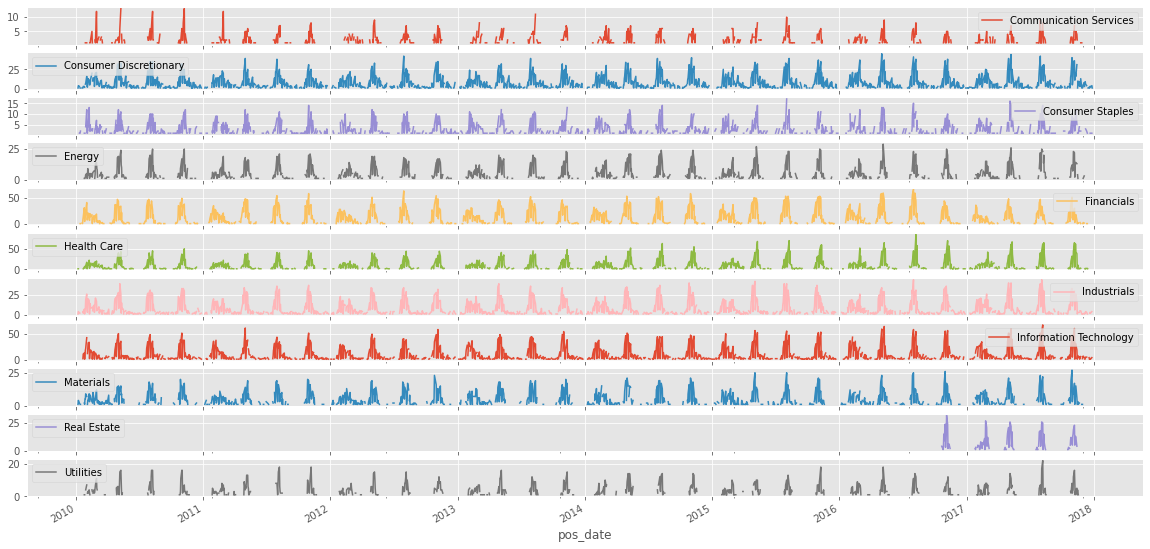

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

print("Plot out daily number of stocks for each sector")
big_df.groupby(['pos_date', 'sector']).size().unstack(level=1).plot(subplots=True)

In [18]:
print(f"Percentage of stocks missing values:\n{round(big_df[dscols].isnull().sum() / len(big_df) * 100, 2)}\n")
print(f"big_df.shape: {big_df.shape}\n")

Percentage of stocks missing values:
d1     2.88
d2     9.41
d3    15.29
d4     2.88
d5     7.00
d6    14.52
d7    13.98
dtype: float64

big_df.shape: (86049, 13)



In [22]:
# each earning period almost covers all tradable securities 
print("Count the number of records within last quarter, this implies good chance of earning print related data")
len(big_df.loc[big_df[dtcol] >= '2017-10-01', seccol].unique())

Count the number of records within last quarter, this implies good chance of earning print related data


2744

In [23]:
big_df = big_df.loc[(big_df['in_trading_universe'] == 'Y') & (big_df[dtcol] >= in_sample_start_date)]

In [24]:
print("big_df.head():\n", big_df.head(), "\n\n")
print("big_df.tail():\n", big_df.tail(), "\n\n")

big_df.head():
        security_id       d1        d2        d3       d4        d5      d6  \
638574     4834101  240.700  1027.200  0.036884  14.9093  0.023635  0.0352   
639114     7040301   20.847    58.591  0.053532   8.5600  0.016256 -0.0772   
640356     2539201  -79.138   340.286  0.052217  21.3572  0.018657  0.0421   
641536     6088601    3.418    93.777  0.084221   7.5465  0.007027 -0.0500   
642061     8262901   54.980   -57.596 -0.037450   2.8802  0.008403  0.1522   

            d7   pos_date  fwdret_f1 in_trading_universe  \
638574 -0.0207 2011-01-06  -0.017135                   Y   
639114 -0.1092 2011-01-06  -0.015192                   Y   
640356 -0.1392 2011-01-07   0.000911                   Y   
641536 -0.0693 2011-01-07  -0.003369                   Y   
642061  0.0906 2011-01-07   0.005268                   Y   

                        sector  clip_trisk  
638574               Materials   41.182594  
639114  Consumer Discretionary   37.802583  
640356  Consumer Di

In [26]:
print(big_df.groupby('sector')[dscols].apply(lambda x: x.notnull().sum()))

                          d1    d2    d3    d4    d5    d6    d7
sector                                                          
Communication Services   767   635   625   775   781   767   768
Consumer Discretionary  7795  7340  7327  7868  7977  7656  7676
Consumer Staples        2263  2149  2127  2230  2241  2220  2220
Energy                  3643  3295  3175  3577  3523  3570  3573
Financials              9345  8780  6366  9603  6791  5081  5088
Health Care             6268  6031  6020  6226  6296  6164  6174
Industrials             6902  6682  6654  6886  6959  6799  6811
Information Technology  8533  8244  8215  8696  8810  8269  8372
Materials               3502  3240  3233  3480  3497  3471  3475
Real Estate              734   711   705   729   731   721   724
Utilities               1960  1865  1861  1952  1969  1950  1952


In [27]:
print("Merging with Alpha9 from Dataset_9")
si_sigs = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'alpha9.csv.gz'), 
                    parse_dates=['pos_date'], 
                    dtype={'security_id': str},
                    compression='gzip')
print(si_sigs)

Merging with Alpha9 from Dataset_9
          pos_date security_id  clip_trisk  fwdret_f1                  sector  \
0       2011-01-03     1004601   62.162621  -0.020927  Information Technology   
1       2011-01-03      100701   19.749199  -0.009325               Utilities   
2       2011-01-03     1007201   37.389405  -0.011587  Consumer Discretionary   
3       2011-01-03     1009601   29.017306  -0.029014        Consumer Staples   
4       2011-01-03    10116101   55.507777   0.007392             Industrials   
...            ...         ...         ...        ...                     ...   
3164808 2017-12-28       97801   13.593583  -0.005100              Financials   
3164809 2017-12-28     9789701   18.560457   0.000000                  Energy   
3164810 2017-12-28      985601   30.191535  -0.013173  Consumer Discretionary   
3164811 2017-12-28      995201   24.067018  -0.008429        Consumer Staples   
3164812 2017-12-28      996501   17.550179  -0.004859             Industri

pos_date
2016-08-01    267
2017-07-31    265
2016-05-02    248
2017-05-01    247
2017-11-06    242
             ... 
2017-02-01     30
2015-02-03     30
2015-07-22     30
2012-10-24     30
2013-08-07     30
Length: 482, dtype: int64


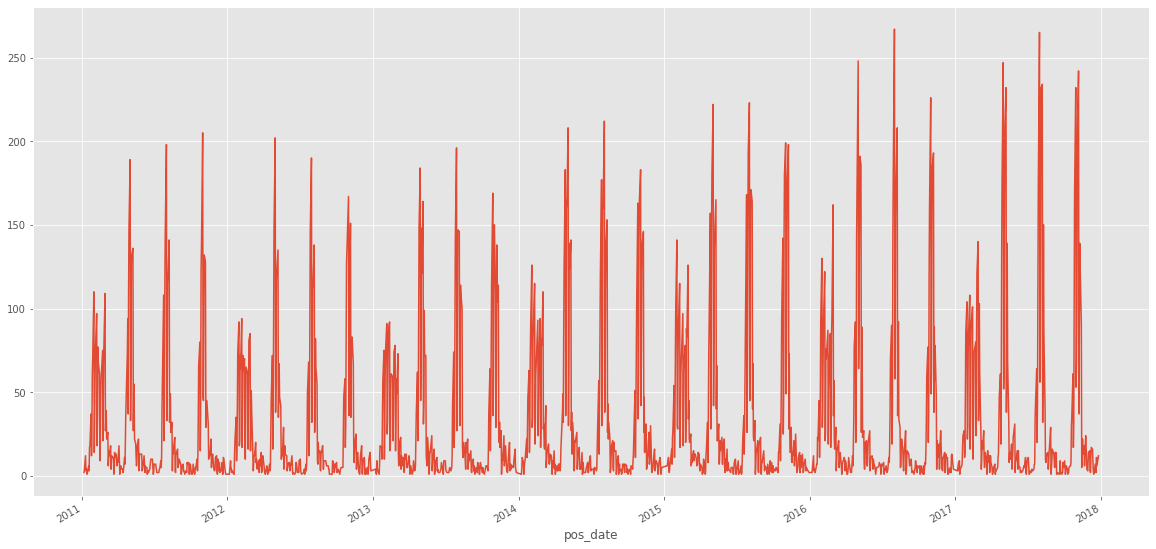

In [28]:

## threshold want to have at least 50 stocks carry signal values 
threshold_n = 30
ncount = big_df.groupby(dtcol).size()
ncount.plot()
ncount = ncount[ncount >= threshold_n]
print(ncount.sort_values(ascending=False))

<AxesSubplot:xlabel='pos_date'>

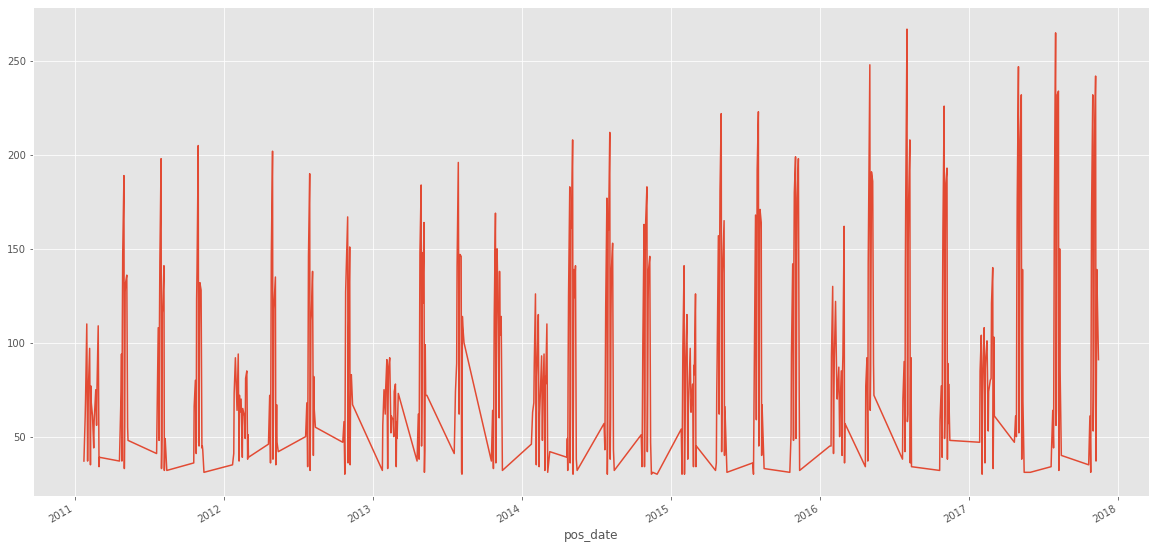

In [29]:
big_df = big_df.loc[big_df[dtcol].isin(ncount.index)]
big_df.groupby(dtcol).size().plot()

In [30]:
for col in dscols:
    print(f" Ranking scorecol {col}...")
    big_df[f'{col}_rank'] = big_df.groupby(dtcol)[col].rank()
    big_df[f'{col}_rank_scale'] = big_df.groupby(dtcol)[f'{col}_rank'].transform(lambda x: x / (len(x) + 1))
    big_df[f'{col}_rank_score'] = norm.ppf(big_df[f'{col}_rank_scale'].values)

 Ranking scorecol d1...
 Ranking scorecol d2...
 Ranking scorecol d3...
 Ranking scorecol d4...
 Ranking scorecol d5...
 Ranking scorecol d6...
 Ranking scorecol d7...


In [31]:
final_alpha_cols = ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd4_rank_score',
                    'd5_rank_score', 'd6_rank_score', 'd7_rank_score']

In [32]:
score_df = big_df[['pos_date', 'security_id', 'fwdret_f1', 'in_trading_universe', 'sector',
                  'clip_trisk'] + final_alpha_cols].copy()
print(score_df.head())

         pos_date security_id  fwdret_f1 in_trading_universe  \
665419 2011-01-24     1221001  -0.005364                   Y   
665507 2011-01-24     1468301   0.001025                   Y   
665575 2011-01-24     1666001   0.001978                   Y   
665622 2011-01-24     1799901   0.013369                   Y   
665784 2011-01-24     2369301   0.007463                   Y   

                        sector  clip_trisk  d1_rank_score  d2_rank_score  \
665419              Financials   35.115179      -0.716498       1.619856   
665507              Financials   30.167862       0.266994       0.199201   
665575               Utilities   19.498901       1.003148      -0.066012   
665622             Health Care   26.967702       0.199201      -0.266994   
665784  Information Technology   36.495834      -0.804596      -1.252120   

        d3_rank_score  d4_rank_score  d5_rank_score  d6_rank_score  \
665419       0.406724      -0.479506      -0.804596      -1.252120   
665507            

In [33]:
score_df[final_alpha_cols] = score_df[final_alpha_cols].fillna(0)

In [34]:
in_sample_scoredf, out_of_sample_df = score_df[score_df['pos_date'].between(in_sample_start_date, in_sample_end_date)], \
                                      score_df[score_df['pos_date'] >= in_sample_end_date]

Alpha1 Stats:
      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011  0.0094  0.0263  66.0  0.3595     78  1.9999
2012  0.0586  0.0202  65.0  2.9006     76  2.0000
2013  0.0374  0.0174  66.0  2.1442     83  1.9996
2014  0.0533  0.0221  76.0  2.4103     87  1.9993
2015  0.0400  0.0192  71.0  2.0818     93  1.9995

Alpha2 Stats:
      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011 -0.0003  0.0286  66.0 -0.0101     78  2.0000
2012  0.0579  0.0320  65.0  1.8081     76  2.0000
2013  0.0363  0.0215  66.0  1.6842     83  1.9990
2014  0.0394  0.0279  76.0  1.4129     87  2.0000
2015  0.0619  0.0267  71.0  2.3219     93  1.9993

Alpha3 Stats:
      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011  0.0003  0.0532  66.0  0.0064     78  2.0000
2012  0.0762  0.0414  65.0  1.8375     76  2.0000
2013  0.0221  0.0218  66.0  1.0162     83  1.9993
2014  

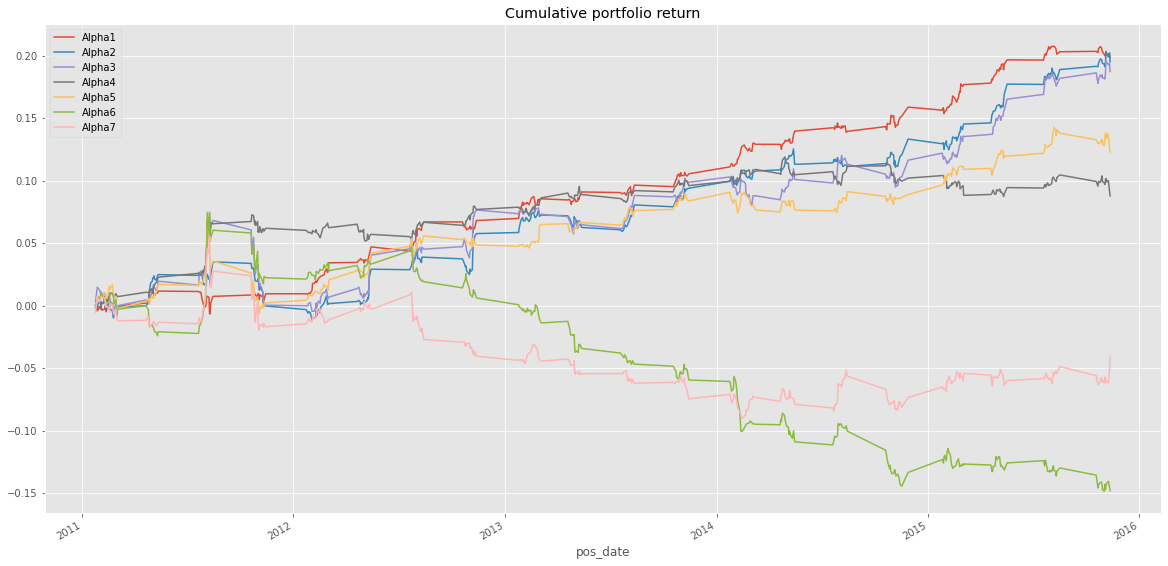

In [37]:
is_daily_ret1, is_stat1 = \
    quickstats(in_sample_scoredf, 'd1_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
is_daily_ret2, is_stat2 = \
    quickstats(in_sample_scoredf, 'd2_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
is_daily_ret3, is_stat3 = \
    quickstats(in_sample_scoredf, 'd3_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
is_daily_ret4, is_stat4 = \
    quickstats(in_sample_scoredf, 'd4_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
is_daily_ret5, is_stat5 = \
    quickstats(in_sample_scoredf, 'd5_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
is_daily_ret6, is_stat6 = \
    quickstats(in_sample_scoredf, 'd6_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
is_daily_ret7, is_stat7 = \
    quickstats(in_sample_scoredf, 'd7_rank_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
plt.legend(['Alpha1', 'Alpha2', 'Alpha3', 'Alpha4', 'Alpha5', 'Alpha6', 'Alpha7'], loc='upper left')


print(f"Alpha1 Stats:\n{is_stat1}\n")
print(f"Alpha2 Stats:\n{is_stat2}\n")
print(f"Alpha3 Stats:\n{is_stat3}\n")
print(f"Alpha4 Stats:\n{is_stat4}\n")
print(f"Alpha5 Stats:\n{is_stat5}\n")
print(f"Alpha6 Stats:\n{is_stat6}\n")
print(f"Alpha7 Stats:\n{is_stat7}\n")


###  Since datasets 1 to 7 are betting on earning prints, maybe topline/bottomline beat or miss, revenue growth, or other KPI dynamics, so I think there are fundamental related dataset, so no need to further split in sample data into train and test. From 2011 to 2016, ds 1, 2 and 5 showed consisten return and sharp for every year, so I choose the equal weighted version as the final score

In [39]:
print("I propose four candidates to combine the well performed factors")

candidate_one_use_scores   = ['d1_rank_score', 'd2_rank_score']
candidate_two_use_scores   = ['d1_rank_score', 'd2_rank_score', 'd3_rank_score']
candidate_three_use_scores = ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd5_rank_score']
candidate_four_use_scores  = ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd5_rank_score', 'd4_rank_score']

I propose four candidates to combine the well performed factors


In [40]:
in_sample_scoredf['candidate_one']   = in_sample_scoredf[candidate_one_use_scores].mean(axis=1)
in_sample_scoredf['candidate_two']   = in_sample_scoredf[candidate_two_use_scores].mean(axis=1)
in_sample_scoredf['candidate_three'] = in_sample_scoredf[candidate_three_use_scores].mean(axis=1)
in_sample_scoredf['candidate_four']  = in_sample_scoredf[candidate_four_use_scores].mean(axis=1)

for candidate_col in ['candidate_one', 'candidate_two', 'candidate_three', 'candidate_four']:
    print(f"Normalizing candidate_col {candidate_col}")
    in_sample_scoredf[f'{candidate_col}_std'] = std_qnt_score(in_sample_scoredf, candidate_col, 'pos_date', demean=True)
    in_sample_scoredf[f'{candidate_col}_std'] = in_sample_scoredf[f'{candidate_col}_std'].clip(-3, 3)

/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Normalizing candidate_col candidate_one


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Normalizing candidate_col candidate_two


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Normalizing candidate_col candidate_three


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Normalizing candidate_col candidate_four


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


candidate_one Stats:
      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011  0.0128  0.0316  66.0  0.4064     78  2.0000
2012  0.0449  0.0196  65.0  2.2915     76  2.0000
2013  0.0493  0.0191  66.0  2.5846     83  1.9994
2014  0.0586  0.0223  76.0  2.6235     87  1.9998
2015  0.0526  0.0237  71.0  2.2177     93  1.9994

candidate_two Stats:
      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011  0.0170  0.0307  66.0  0.5545     78  2.0000
2012  0.0460  0.0190  65.0  2.4255     76  2.0000
2013  0.0547  0.0188  66.0  2.9080     83  1.9994
2014  0.0571  0.0247  76.0  2.3141     87  1.9999
2015  0.0574  0.0250  71.0  2.2934     93  1.9992

candidate_three Stats:
      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011  0.0143  0.0301  66.0  0.4740     78  2.0000
2012  0.0531  0.0207  65.0  2.5669     76  2.0000
2013  0.0623  0.0191  66.0  3.261

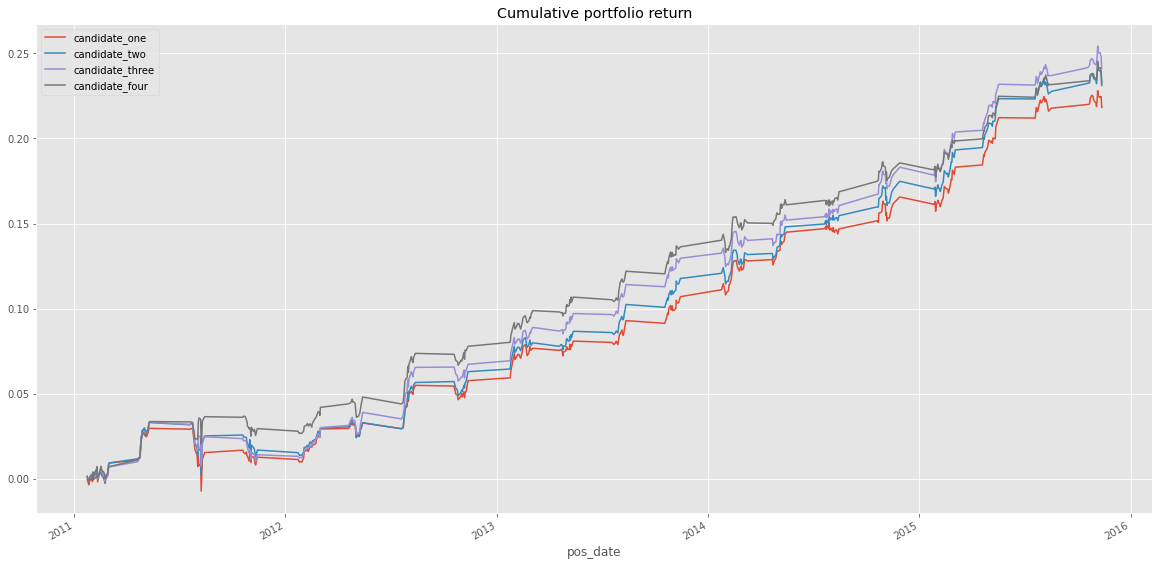

In [41]:
is_candidate_one_ret, is_candidate_one_stats = \
    quickstats(in_sample_scoredf, 'candidate_one_std', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

is_candidate_two_ret, is_candidate_two_stats = \
    quickstats(in_sample_scoredf, 'candidate_two_std', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

is_candidate_three_ret, is_candidate_three_stats = \
    quickstats(in_sample_scoredf, 'candidate_three_std', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

is_candidate_four_ret, is_candidate_four_stats = \
    quickstats(in_sample_scoredf, 'candidate_four_std', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.legend(['candidate_one', 'candidate_two', 'candidate_three', 'candidate_four'], loc='upper left')

print(f"candidate_one Stats:\n{is_candidate_one_stats}\n")
print(f"candidate_two Stats:\n{is_candidate_two_stats}\n")
print(f"candidate_three Stats:\n{is_candidate_three_stats}\n")
print(f"candidate_four Stats:\n{is_candidate_four_stats}\n")

In [42]:
in_sample_scoredf[[col + '_std' for col in ['candidate_one', 'candidate_two', 'candidate_three', 'candidate_four']]].head()

candidate_one_std  candidate_two_std  candidate_three_std  \
665419           0.526078           0.789386             0.518069   
665507           0.271492           0.373306             0.499349   
665575           0.545748          -0.090777            -0.142885   
665622          -0.039480           0.383628             0.773714   
665784          -1.197744          -1.144224            -1.890388   

        candidate_four_std  
665419            0.256343  
665507            0.018945  
665575           -0.210478  
665622            0.986994  
665784           -2.490492

      AnnRet  AnnVol  Days   AnnSR  Count   AnnTO
year                                             
2011  0.0143  0.0301  66.0  0.4740     78  2.0000
2012  0.0531  0.0207  65.0  2.5669     76  2.0000
2013  0.0623  0.0191  66.0  3.2618     83  1.9993
2014  0.0535  0.0255  76.0  2.1004     87  2.0000
2015  0.0578  0.0250  71.0  2.3159     93  1.9991


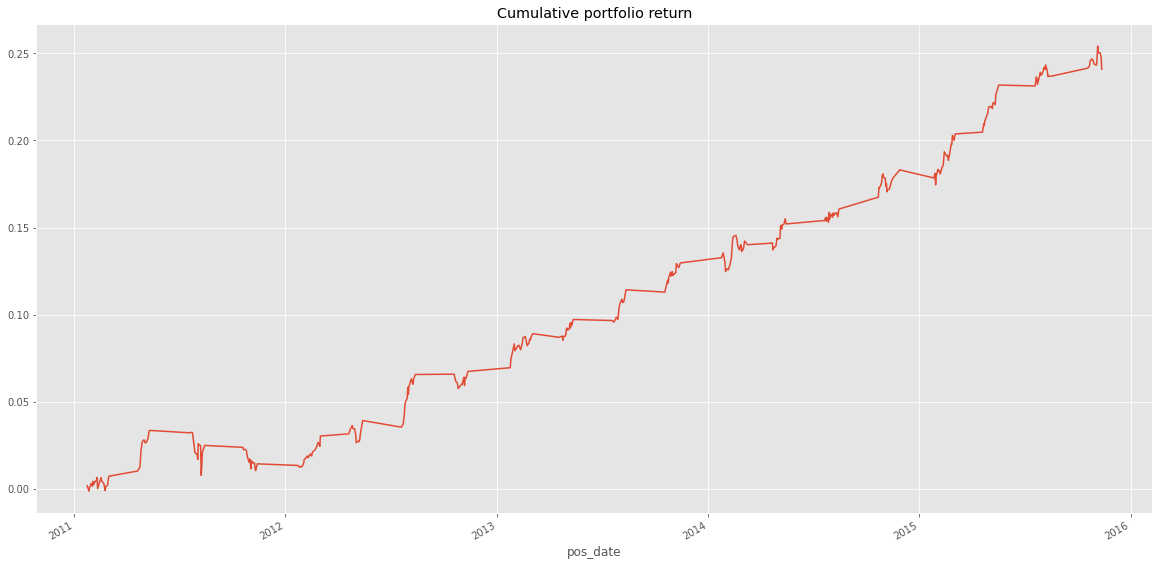

In [43]:
is_daily_combined, is_stat_combined = quickstats(in_sample_scoredf, 'candidate_three_std', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(is_stat_combined)

In [44]:
print("Calc Yearly MaxDD and the Length of the in-sample performance \n\n")

is_daily_combined['year'] = is_daily_combined['pos_date'].dt.year
print(is_daily_combined.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(is_daily_combined.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length of the in-sample performance 


      Max_Drawdown  Length
year                      
2011        -0.026    13.0
2012        -0.010     5.0
2013        -0.005     2.0
2014        -0.011     2.0
2015        -0.013     4.0 

Max Drawdown of all times:
 Max_Drawdown    -0.026
Length          13.000
dtype: float64


In [45]:
print("Compute % of positive portfolio return days for each year in-sample:")
is_daily_combined.loc[is_daily_combined['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year in-sample:


year
2011    53.03
2012    61.54
2013    68.18
2014    68.42
2015    59.15
Name: attr_fwdretf1, dtype: float64

In [46]:
out_of_sample_df['combined_score'] = out_of_sample_df[candidate_three_use_scores].mean(axis=1)

print("Re-normalize...")
out_of_sample_df['combined_score_std'] = std_qnt_score(out_of_sample_df, 'combined_score', 'pos_date', demean=True)
out_of_sample_df['combined_score_std'] = out_of_sample_df['combined_score_std'].clip(-3, 3)

/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Re-normalize...


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


      AnnRet  AnnVol  Days   AnnSR  Count  AnnTO
year                                            
2016  0.0630  0.0281  67.0  2.2425     97    2.0
2017  0.0394  0.0180  71.0  2.1892    100    2.0


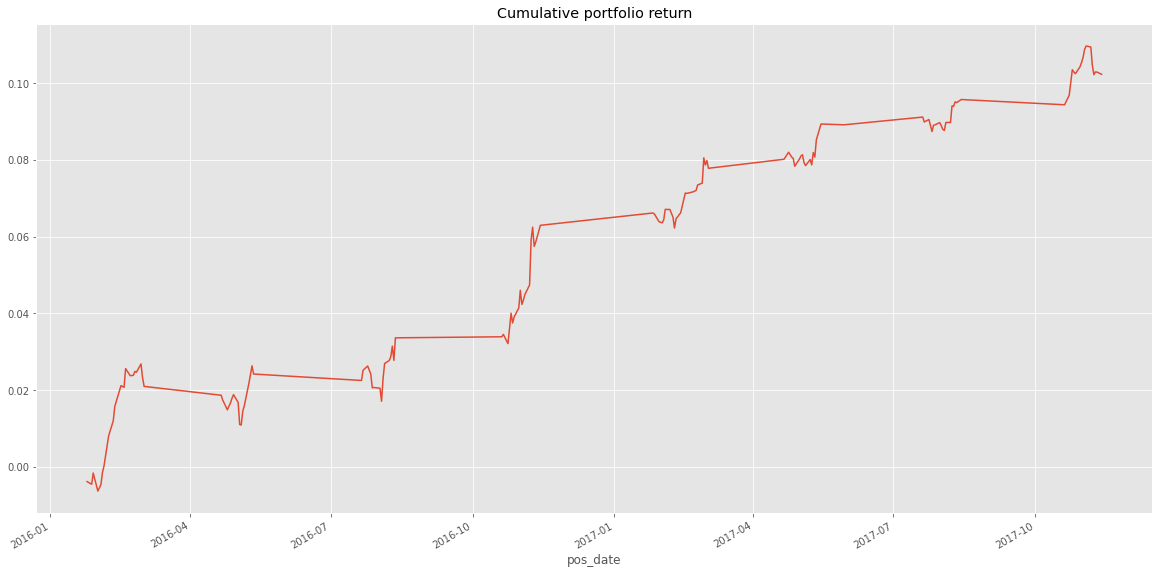

In [47]:
os_daily_combined, os_stat_combined = quickstats(out_of_sample_df, 'combined_score_std', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(os_stat_combined)

In [48]:
print("Calc Yearly MaxDD and the Length of the out-of-sample performance \n\n")

os_daily_combined['year'] = os_daily_combined['pos_date'].dt.year
print(os_daily_combined.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(os_daily_combined.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length of the out-of-sample performance 


      Max_Drawdown  Length
year                      
2016        -0.016    11.0
2017        -0.007     3.0 

Max Drawdown of all times:
 Max_Drawdown    -0.016
Length          11.000
dtype: float64


In [49]:
print("Compute % of positive portfolio return days for each year out-of-sample:")
os_daily_combined.loc[os_daily_combined['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year out-of-sample:


year
2016    61.19
2017    54.93
Name: attr_fwdretf1, dtype: float64

<AxesSubplot:>

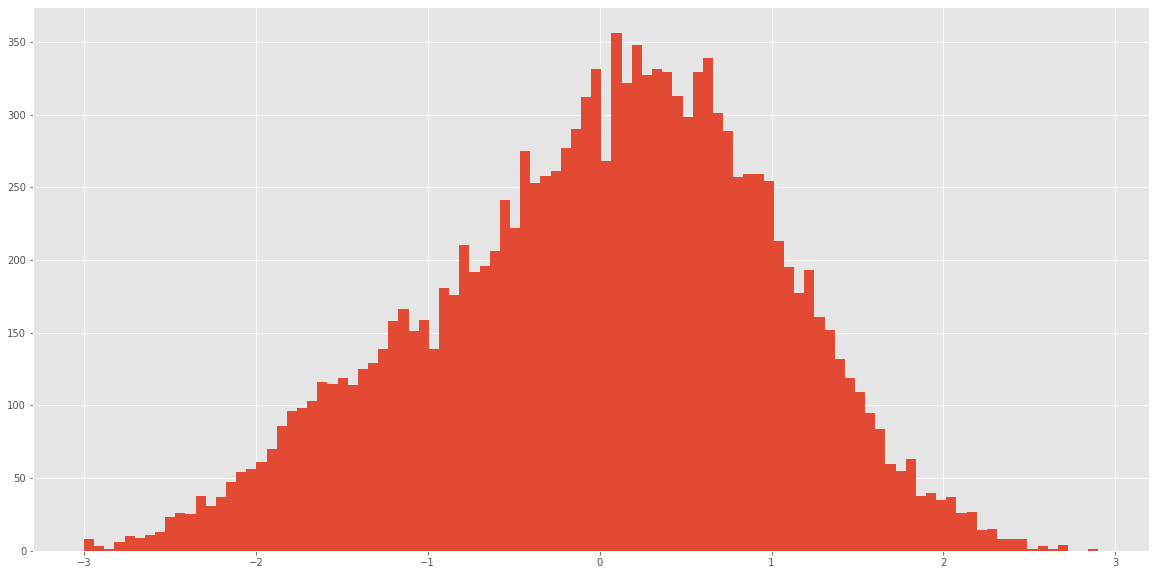

In [50]:
out_of_sample_df['combined_score_std'].hist(bins=100)

In [51]:
score_df = score_df[[dtcol, seccol] + ['d1_rank_score', 'd2_rank_score', 'd3_rank_score']]

In [52]:
# score_df.to_csv(os.path.join(data_root, 'new_processed_csvs/new_alpha1_7.csv.gz'), index=False, compression='gzip')

In [54]:
enhenced_df = pd.merge(si_sigs, 
                       score_df[[dtcol, seccol] + ['d1_rank_score', 'd2_rank_score', 'd3_rank_score']], 
                       on=[dtcol, seccol], how='left')

In [55]:
enhenced_df.loc[enhenced_df['d1_rank_score'].notnull()].sample(10)

pos_date security_id  clip_trisk  fwdret_f1                  sector  \
3091301 2017-11-06     3291501   14.606377   0.008276               Utilities   
2462724 2016-08-02     3565301   32.380885   0.020525                  Energy   
37863   2011-02-04     1043001   40.336693   0.034455  Information Technology   
2240037 2016-02-16     8251101   30.493867   0.049383                  Energy   
1251312 2014-02-05     8296401   23.213083   0.008931  Consumer Discretionary   
1603308 2014-10-24    33160201   40.609605  -0.013486  Consumer Discretionary   
814091  2013-02-01     4645101   32.219959  -0.021131               Materials   
631665  2012-08-08     1120801   46.971841   0.026178               Materials   
2951922 2017-07-28    33078201   18.449431   0.010689              Financials   
2225763 2016-02-04     2318801   29.502597  -0.018899             Health Care   

         z63_score  z126_score  z252_score  combined_score  d1_rank_score  \
3091301   0.005578   -0.403856   -0.920682       -0.471173      -0.192007   
2462724   0.073052    0.075777    0.058723        0.074613       0.369353   
37863     0.094249    0.554183    0.292455        0.335015       0.314361   
2240037   2.062319    2.088520    2.059401        2.210297       0.472789   
1251312   1.207082    1.163998    0.803493        1.136546       0.508488   
1603308  -1.195398   -1.382330   -1.920988       -1.607792      -1.480973   
814091         NaN    0.107998    0.158712        0.141791      -0.301337   
631665    0.140177    0.032909   -0.252850       -0.028083       1.452576   
2951922   0.424204    0.737498    0.496353        0.595999       0.203070   
2225763  -0.296320   -0.511570   -0.852452       -0.592266      -0.104633   

         d2_rank_score  d3_rank_score  
3091301      -0.645631      -0.620423  
2462724      -0.369353      -0.509832  
37863        -0.246630       1.190713  
2240037       0.441169       1.046231  
1251312       0.674490      -0.764710  
1603308      -1.346263      -1.346263  
814091        0.000000       0.099108  
631665        0.951278       0.859175  
2951922      -0.043231      -0.720423  
2225763       0.246164      -0.469253

In [56]:
enhenced_df['enhenced'] = enhenced_df[['combined_score', 'd1_rank_score', 'd2_rank_score', 'd3_rank_score']].mean(axis=1)

In [57]:
enhenced_df['enhenced_score'] = std_qnt_score(enhenced_df, 'enhenced', 'pos_date', demean=True)
enhenced_df['enhenced_score'] = enhenced_df['enhenced_score'].clip(-3, 3)

Running analyzer for Alpha9 alpha:

Running analyzer for enhenced Alpha9 alpha:



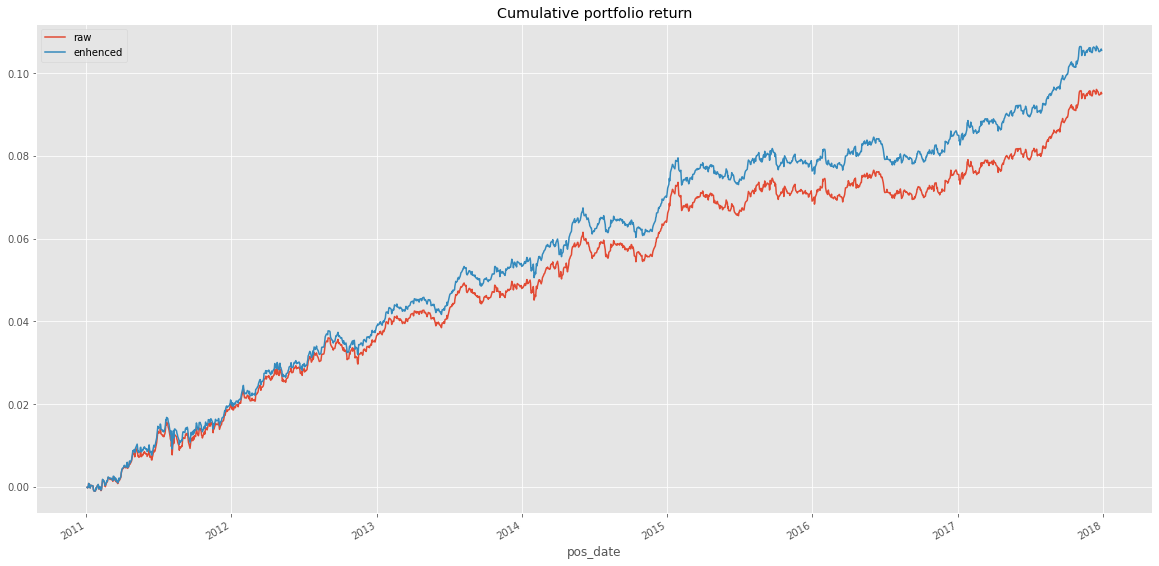

In [58]:
print("Running analyzer for Alpha9 alpha:\n")
daily_return_raw, ann_stats_raw = \
    quickstats(enhenced_df, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

print("Running analyzer for enhenced Alpha9 alpha:\n")
daily_return_enhenced, ann_stats_enhenced = \
    quickstats(enhenced_df, 'enhenced_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.legend(['raw', 'enhenced'], loc='upper left')

In [59]:
print(ann_stats_raw)
print(ann_stats_enhenced)

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0201  0.0115  252.0  1.7550   1587  0.2215
2012  0.0164  0.0089  250.0  1.8397   1523  0.2270
2013  0.0114  0.0075  252.0  1.5288   1688  0.2202
2014  0.0166  0.0097  252.0  1.7081   1927  0.2328
2015  0.0045  0.0101  252.0  0.4476   1948  0.2249
2016  0.0066  0.0089  252.0  0.7332   1914  0.2156
2017  0.0195  0.0090  250.0  2.1612   1996  0.2131
      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0210  0.0116  252.0  1.8183   1587  0.2396
2012  0.0178  0.0090  250.0  1.9878   1523  0.2449
2013  0.0145  0.0075  252.0  1.9283   1688  0.2390
2014  0.0173  0.0097  252.0  1.7789   1927  0.2506
2015  0.0058  0.0100  252.0  0.5754   1948  0.2441
2016  0.0087  0.0089  252.0  0.9845   1914  0.2345
2017  0.0205  0.0091  250.0  2.2580   1996  0.2324


In [60]:
print("Calc Yearly MaxDD and the Length for Enhanced Alpha9")

print(daily_return_enhenced.head())
daily_return_enhenced['year'] = daily_return_enhenced['pos_date'].dt.year
print(daily_return_enhenced.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(daily_return_enhenced.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length
    pos_date  attr_fwdretf1
0 2011-01-03      -0.000092
1 2011-01-04      -0.000159
2 2011-01-05       0.000071
3 2011-01-06       0.000126
4 2011-01-07       0.000872
      Max_Drawdown  Length
year                      
2011        -0.008    10.0
2012        -0.006    50.0
2013        -0.005    30.0
2014        -0.007    93.0
2015        -0.007     7.0
2016        -0.007    32.0
2017        -0.003    16.0 

Max Drawdown of all times:
 Max_Drawdown    -0.008
Length          10.000
dtype: float64


In [61]:
print("Compute % of positive portfolio return days for each year:")
daily_return_enhenced.loc[daily_return_enhenced['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    56.35
2012    57.20
2013    55.16
2014    59.52
2015    53.17
2016    51.19
2017    55.60
Name: attr_fwdretf1, dtype: float64

In [62]:
print("Calc Yearly MaxDD and the Length for Raw Alpha9")

print(daily_return_raw.head())
daily_return_raw['year'] = daily_return_raw['pos_date'].dt.year
print(daily_return_raw.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(daily_return_raw.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length for Raw Alpha9
    pos_date  attr_fwdretf1
0 2011-01-03      -0.000092
1 2011-01-04      -0.000159
2 2011-01-05       0.000071
3 2011-01-06       0.000126
4 2011-01-07       0.000872
      Max_Drawdown  Length
year                      
2011        -0.008    10.0
2012        -0.006    50.0
2013        -0.005    30.0
2014        -0.007    93.0
2015        -0.008   105.0
2016        -0.007    67.0
2017        -0.004    16.0 

Max Drawdown of all times:
 Max_Drawdown     -0.008
Length          105.000
dtype: float64


In [63]:
print("Compute % of positive portfolio return days for each year:")
daily_return_raw.loc[daily_return_raw['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    56.35
2012    57.20
2013    52.78
2014    58.33
2015    53.57
2016    50.79
2017    55.60
Name: attr_fwdretf1, dtype: float64